#<center>**MDSC 302 Assignment**</center>

##Reg no. - 20237

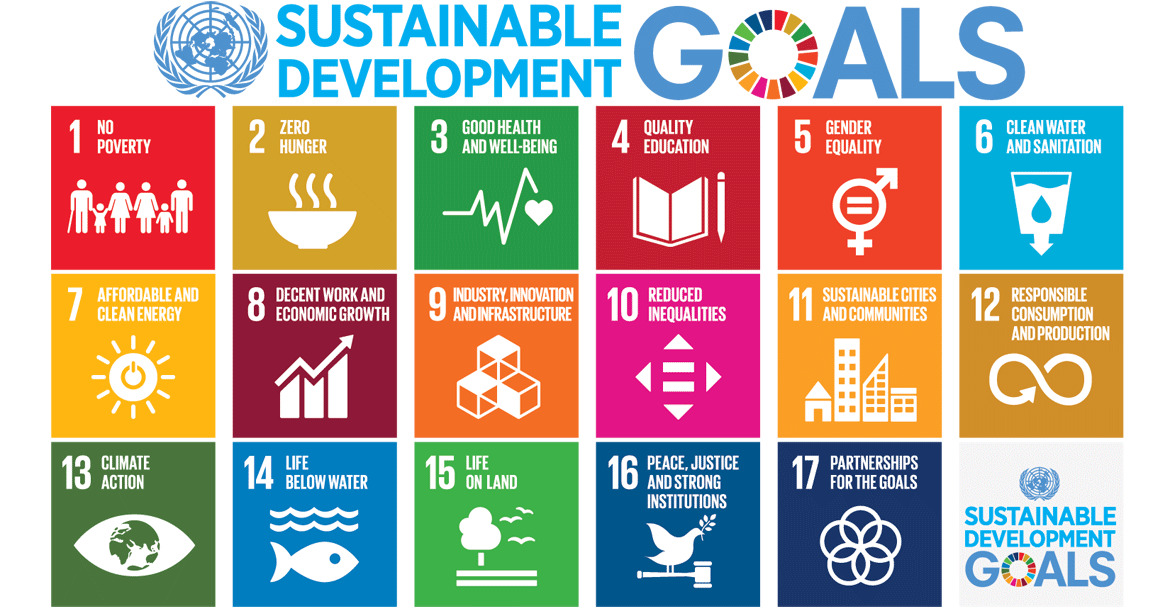

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, f1_score
import nltk

import re
from nltk.tokenize import word_tokenize 
sns.set_theme()
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Data preparation

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Dataset for 302 UN assignment/osdg-community-dataset-v21-09.csv')

# keeping only the texts whose suggested sdg labels is accepted and the agreement score is at least .6
print('Shape before:', df.shape)
df = df.query('agreement >= .6 and labels_positive > labels_negative').copy()
print('Shape after :', df.shape)
display(df.head())

Shape before: (32121, 7)
Shape after : (17233, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000


Text preprocessing

In [ ]:
from nltk.corpus import stopwords 

stopwords= stopwords.words('english')


def cleanText(text):
    text = re.sub(r'''!\(\)-\[]\{};:'"\,<>./?@#$%^&*_~''', r' ', text) 
    text = text.lower()
    text = text.replace(',', '')
    tokens = nltk.word_tokenize(text)
    wordlist = [] 
    for w in tokens:
      if w not in stopwords:
        if w.isalpha():
          wordlist.append(w)

    clean_text = ' '.join(wordlist)
    return clean_text
    
df['clean_text'] = df['text'].apply(cleanText)

Preparing data for model

In [ ]:
X = df['clean_text']
y = df['sdg']
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sdg'], test_size = .3, random_state = 42)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (12063,)
Test shape: (5170,)


##Creating pipeling to vectorise text and train model.
(Referred from OSDG github repo)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(
        ngram_range = (1, 2),
        max_df = 0.75,
        min_df = 2,
        max_features = 100_000
    )),
    ('selector', SelectKBest(f_classif, k = 5_000)),
    ('clf', LogisticRegression(
        penalty = 'l2',
        C = .9,
        multi_class = 'multinomial',
        class_weight = 'balanced',
        random_state = 42,
        solver = 'newton-cg',
        max_iter = 100
    ))
])

pipe.fit(X, y)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.75, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('selector', SelectKBest(k=5000)),
                ('clf',
                 LogisticRegression(C=0.9, class_weight='balanced',
                                    multi_class='multinomial', random_state=42,
                                    solver='newton-cg'))])

##Function to plot confusion matrix
(Referred from OSDG github repo)

In [ ]:
def plot_confusion_matrix(y_true: np.ndarray, y_hat: np.ndarray, figsize = (15, 10)):
    # Getting labels
    labels = sorted(list(set(y_true)))
    
    # Creating confusion matrix
    df = pd.DataFrame(confusion_matrix(y_true, y_hat), index = labels, columns = labels)
    
    # Accuracy and F1-score
    acc = accuracy_score(y_true, y_hat)
    f1s = f1_score(y_true, y_hat, average = 'weighted')
    
    # Ploting Confusin matrix
    fig, ax = plt.subplots(figsize = figsize)
    sns.heatmap(df, annot = True, square = True, fmt = 'd', linewidths = 1,cbar = False, cmap = 'Paired', ax = ax)
    ax.set(title = f'Accuracy: {acc:.2f}, F1 score: {f1s:.2f}', xlabel = 'Predicted', ylabel = 'Actual')
    fig.suptitle('Confusion Matrix')
    plt.tight_layout()

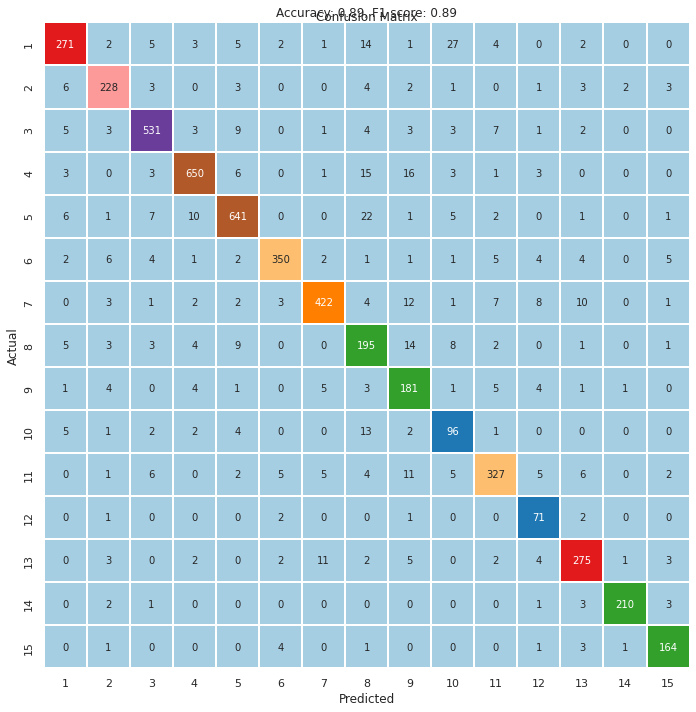

In [ ]:
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

In [ ]:
print(classification_report(y_test, y_hat, zero_division = 0))

              precision    recall  f1-score   support

           1       0.89      0.80      0.85       337
           2       0.88      0.89      0.89       256
           3       0.94      0.93      0.93       572
           4       0.95      0.93      0.94       701
           5       0.94      0.92      0.93       697
           6       0.95      0.90      0.93       388
           7       0.94      0.89      0.91       476
           8       0.69      0.80      0.74       245
           9       0.72      0.86      0.79       211
          10       0.64      0.76      0.69       126
          11       0.90      0.86      0.88       379
          12       0.69      0.92      0.79        77
          13       0.88      0.89      0.88       310
          14       0.98      0.95      0.97       220
          15       0.90      0.94      0.92       175

    accuracy                           0.89      5170
   macro avg       0.86      0.88      0.87      5170
weighted avg       0.90   

##Key predictors for the model
(Referred from OSDG github repo)

In [ ]:
vectoriser = pipe['vectoriser']
selector = pipe['selector']
clf = pipe['clf']

top_n = 15
features =  pipe['vectoriser'].get_feature_names_out()
if selector is not None:
    features = features[selector.get_support()]
axis_names = [f'freature_{x + 1}' for x in range(top_n)]

if len(clf.classes_) > 2:
    results = list()
    for c, coefs in zip(clf.classes_, clf.coef_):
        idx = coefs.argsort()[::-1][:top_n]
        results.extend(tuple(zip([c] * top_n, features[idx], coefs[idx])))
else:
  coefs = clf.coef_.flatten()
  idx = coefs.argsort()[::-1][:top_n]
  results = tuple(zip([clf.classes_[1]] * top_n, features[idx], coefs[idx]))

df_lambda = pd.DataFrame(results, columns =  ['sdg', 'feature', 'coef'])
print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (225, 3)


,sdg,feature,coef
0,1,poverty,14.392773
1,1,poor,8.123219
2,1,deprivation,5.046636
3,1,income,5.031031
4,1,children,4.852034


In [ ]:
df_lambda.sort_values(['sdg', 'coef'], ignore_index = True, inplace = True)

colors = px.colors.qualitative.Dark24[:15]
template = 'SDG: %{customdata}<br>Feature: %{y}<br>Coefficient: %{x:.2f}'

fig = px.bar(
    data_frame = df_lambda,
    x = 'coef',
    y = 'feature',
    custom_data = ['sdg'],
    facet_col = 'sdg',
    facet_col_wrap = 3,
    #facet_col_spacing = .15,
    orientation = 'h',
    height = 1200,
    labels = {
        'coef': 'Coefficient',
        'feature': ''
    },
    title = 'Figure 3. Top 15 Strongest Predictors by SDG'
)

fig.for_each_trace(lambda x: x.update(hovertemplate = template))
fig.for_each_trace(lambda x: x.update(marker_color = colors.pop(0)))
fig.update_yaxes(matches = None, showticklabels = True)

fig.show()

##Taking sample text for prediction to find top predictors in sample text.

In [ ]:
df.reset_index(inplace = True)
sample = df.clean_text[0]
sample = sample.split(' ')

predictors = []
for i, word in enumerate(df_lambda['feature'].values):
  if word in sample:
    predictors.append((df_lambda['sdg'][i], word, df_lambda['coef'][i]))

df_pred = pd.DataFrame(predictors, columns = ['sdg', 'predictors', 'coef'])
df_pred.head()

,sdg,predictors,coef
0,1,people,2.084905
1,4,school,7.688216
2,5,male,2.499951
3,5,work,2.720335
4,5,men,4.288277


In [ ]:
df_pred.sort_values(['sdg', 'coef'], ignore_index = True, inplace = True)
colors = px.colors.qualitative.Dark24[:15]
template = 'SDG: %{customdata}<br>Predictor: %{y}<br>Coefficient: %{x:.2f}'

fig = px.bar(
    data_frame = df_pred,
    x = 'coef',
    y = 'predictors',
    custom_data = ['sdg'],
    facet_col = 'sdg',
    facet_col_wrap = 4,
    #facet_col_spacing = .10,
    orientation = 'h',
    #height = 450,
    labels = {
        'coef': 'Coefficient',
        'predictors': ''
    },
    title = 'Strongest Predictor words in given document'
)

fig.for_each_trace(lambda x: x.update(hovertemplate = template))
fig.for_each_trace(lambda x: x.update(marker_color = colors.pop(0)))
fig.update_yaxes(matches = None, showticklabels = True)

fig.show()

##Classifying sdg for sample text

In [ ]:
sample = df.text[0]
sample = [sample]

pipe.predict(sample)

array([5])

In [ ]:
df.sdg[0]

5

In [ ]:
prediction = pipe.predict_proba(sample)
prediction = prediction[0]
prediction

array([0.03647695, 0.3236781 , 0.03102052, 0.01758479, 0.01534901,
       0.13495376, 0.05660108, 0.02915969, 0.027837  , 0.06938324,
       0.0505222 , 0.02039499, 0.14202705, 0.02110666, 0.02390497])

In [ ]:
for index,value in enumerate(prediction):
  if value > 0.1:
    print(index+1, round(value,2))

2 0.32
6 0.13
13 0.14


In [ ]:
for index, value in enumerate(prediction):
    print(index, value)

0 0.06507691554762515
1 0.010564679098569589
2 0.022375249273823058
3 0.019531977832286322
4 0.08211373057615577
5 0.013120973743156709
6 0.011666398566738512
7 0.4900178537711698
8 0.014116911955191764
9 0.15980773813590698
10 0.07054182367913364
11 0.016198329554049585
12 0.004400043773404468
13 0.007671197553613989
14 0.012796176939174547
